In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
#part of code from article https://www.oxford-man.ox.ac.uk/wp-content/uploads/2020/06/ANOMALY-DETECTION-FOR-TIME-SERIES-USING-VAE-LSTM-HYBRID-MODEL.pdf

!ls "/content/drive/MyDrive/Colab Notebooks/Red"
!cp "/content/drive/MyDrive/Colab Notebooks/Red/base.py" base.py
!cp "/content/drive/MyDrive/Colab Notebooks/Red/data_loader.py" data_loader.py
!cp "/content/drive/MyDrive/Colab Notebooks/Red/utils.py" utils.py

base.py		  models.py		       trainers.py
data_loader.py	  NAB_anomaly_detection.ipynb  train.py
machine_temp.npz  NAB_config.json	       utils.py


In [3]:
# Copy npz from gdrive!
!mkdir -p  '../datasets/NAB-known-anomaly'
!cp "/content/drive/MyDrive/Colab Notebooks/Red/machine_temp.npz"  "/datasets/NAB-known-anomaly/machine_temp.npz"

In [4]:
import os
import time
import random
import json
from datetime import datetime

import pdb
from IPython.core.debugger import set_trace
#set_trace() %debug

import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

import matplotlib.pyplot as plt
from matplotlib.pyplot import savefig
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn import preprocessing

import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataset import random_split
from torch.utils.data import TensorDataset, Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import datasets

from data_loader import DataGenerator

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
experimental_compile is deprecated, use jit_compile instead


In [5]:
def process_config(json_file):
  config = get_config_from_json(json_file)

  # create directories to save experiment results and trained models
  if config['load_dir'] == "default":
    save_dir = "../experiments/local-results/{}/{}/batch-{}".format(
      config['exp_name'], config['dataset'], config['batch_size'])
  else:
    save_dir = config['load_dir']
  # specify the saving folder name for this experiment
  if config['TRAIN_sigma'] == 1:
    save_name = '{}-{}-{}-{}-{}-trainSigma'.format(config['exp_name'],
                                                   config['dataset'],
                                                   config['l_win'],
                                                   config['l_seq'],
                                                   config['code_size'])
  else:
    save_name = '{}-{}-{}-{}-{}-fixedSigma-{}'.format(config['exp_name'],
                                                      config['dataset'],
                                                      config['l_win'],
                                                      config['l_seq'],
                                                      config['code_size'],
                                                      config['sigma'])
  config['summary_dir'] = os.path.join(save_dir, save_name, "summary/")
  config['result_dir'] = os.path.join(save_dir, save_name, "result/")
  config['checkpoint_dir'] = os.path.join(save_dir, save_name, "checkpoint/")
  config['checkpoint_dir_lstm'] = os.path.join(save_dir, save_name, "checkpoint/lstm/")

  return config

In [6]:
def get_config_from_json(json_file):
  """
  Get the config from a json file
  :param json_file:
  :return: config(dictionary)
  """
  # parse the configurations from the config json file provided
  with open(json_file, 'r') as config_file:
    config_dict = json.load(config_file)

  return config_dict

In [7]:
def create_dirs(dirs):
  """
  dirs - a list of directories to create if these directories are not found
  :param dirs:
  :return exit_code: 0:success -1:failed
  """
  try:
    for dir_ in dirs:
      if not os.path.exists(dir_):
        os.makedirs(dir_)
    return 0
  except Exception as err:
    print("Creating directories error: {0}".format(err))
    exit(-1)

VAE-LSTM hybrid model

In [10]:
class VAEmodel(nn.Module):
    def __init__(self, config):
        super(VAEmodel, self).__init__()
        
        self.config = config
        self.two_pi = torch.tensor(2 * np.pi)
        
        self.C = self.config['n_channel'] #1
        self.WIN = self.config['l_win']  #48
        self.H = self.config['num_hidden_units']   #512
        self.input_dims = self.WIN * self.C # 48

        self.build_model()
        self.sigma()

    
    def forward(self, x):
        h, z, mu, std = self.encoder(x)
        output = self.decoder(z)
        return output, h, mu, std 
    
    def sigma(self):
        sigma = torch.Tensor([self.config['sigma']])
        sigma2_offset = torch.Tensor([self.config['sigma2_offset']])
        self.sigma2 = torch.square(sigma)
        if self.config['TRAIN_sigma'] == 1:
            self.sigma2 = self.sigma2 + sigma2_offset

    
    def define_loss(self, input, output, mu, gamma):

    #   KL divergence loss       
        KL_loss = 0.5 * (torch.sum(torch.square(mu), 1)
                          + torch.sum(torch.square(gamma), 1)
                          - torch.sum(torch.log(torch.square(gamma)), 1)
                          - self.config['code_size'])
        KL_loss = torch.mean(KL_loss)
        # print('KL loss', KL_loss)

    #   norm 1 of standard deviation of the sample-wise encoder prediction
        std_dev_norm = torch.mean(gamma, axis=0)

        weighted_reconstruction_error_dataset = torch.sum(torch.square(input - output), [1, 2])      
        weighted_reconstruction_error_dataset = torch.mean(weighted_reconstruction_error_dataset)
        weighted_reconstruction_error_dataset = weighted_reconstruction_error_dataset / (2 * self.sigma2)
        # print('weighted_reconstruction_error_dataset', weighted_reconstruction_error_dataset)

    #   least squared reconstruction error
        ls_reconstruction_error = torch.sum(torch.square(input - output), [1, 2])
        ls_reconstruction_error = torch.mean(ls_reconstruction_error)
        # print('ls_reconstruction_error', ls_reconstruction_error)

    #   sigma regularisor - input elbo
        sigma_regularisor_dataset = self.input_dims / 2 * torch.log(self.sigma2)   

        two_pi = self.input_dims / 2 * torch.Tensor([2 * np.pi])
        elbo_loss = two_pi + sigma_regularisor_dataset + 0.5 * weighted_reconstruction_error_dataset + KL_loss   
        # print('elbo_loss', elbo_loss)

        return elbo_loss, KL_loss, weighted_reconstruction_error_dataset, ls_reconstruction_error, self.sigma2, sigma_regularisor_dataset

    
    def reparameterize(self, mu, gamma):  
        std = torch.exp(0.5 * gamma)
        eps = torch.randn_like(std)   
        z = eps.mul(std).add(mu)
        return  z
        
    def encoder(self, x):

        x = x.view(-1, 1, self.WIN, 1).float()

        x = F.leaky_relu(self.conv_1(x))                 
        x = F.leaky_relu(self.conv_2(x))                  
        x = F.leaky_relu(self.conv_3(x))                 
        x = F.leaky_relu(self.conv_4(x)) 
                
        h = torch.squeeze(x)                      
        x = F.leaky_relu(self.fc_5(h))   
                  
        mu = self.fc_mu(x)      
        std = F.relu(self.fc_std(x))    
        std = std + 1e-2
        z = self.reparameterize(mu, std)

        return h, z, mu, std
    
    def decoder(self, x): # 32, 6

        x = F.leaky_relu(self.fc_1(x)) 
        x = x.view(-1, 512, 1, 1) 

        x = F.leaky_relu(self.dec_2(x))
        x = x.view(-1, 256, 3, 1) 

        x = F.leaky_relu(self.dec_3(x))#
        x = torch.pixel_shuffle(x,2)
        x = x.view(-1, 128, 6, 1)  

        x = F.leaky_relu(self.dec_4(x))
        x = torch.pixel_shuffle(x,2)
        x = x.view(-1, 32, 24, 1)      
 
        x = F.leaky_relu(self.dec_5(x))#
        x = torch.pixel_shuffle(x,2) 
        x = x.view(-1, 16, 48, 1)   

        x = F.leaky_relu(self.dec_6(x))    
        x = x.view(-1, 1, 48, 1)  

        return x
    
    def build_model(self):
               
        #in_channels, out_channels, kernel_size, stride, padding
        self.conv_1 = nn.Conv2d(1, 32, (3,1), stride=2, padding=(1,0))   
        self.conv_2 = nn.Conv2d(32, 64, (3,1), stride=2, padding=(1,0))
        self.conv_3 = nn.Conv2d(64, 128, (3,1), stride=2, padding=(1,0))
        self.conv_4 = nn.Conv2d(128, 512, (6,1), stride=1, padding=(0,0))
        self.fc_5 = nn.Linear(512, 24)
        self.fc_mu = nn.Linear(24, 6)
        self.fc_std = nn.Linear(24, 6)
        self.fc_1 = nn.Linear(6, 512)  
        self.dec_2 = nn.Conv2d(512, 768, 1, stride=1, padding=0)      
        self.dec_3 = nn.Conv2d(256, 256, (3,1), stride=1, padding=(1,0)) 
        self.dec_4 = nn.Conv2d(128, 128, (3,1), stride=1, padding=(1,0)) 
        self.dec_5 = nn.Conv2d(32, 32, (3,1), stride=1, padding=(1,0)) 
        self.dec_6 = nn.Conv2d(16, 1, (5,1), stride=1, padding=(2,0))        
        

        


In [28]:
class LSTMmodel(nn.Module):

  def __init__(self, config):

    super(LSTMmodel, self).__init__()

    self.LSTM1 = nn.LSTM(input_size = config['code_size'], hidden_size = config['num_hidden_units_lstm'], batch_first = True) 
    self.LSTM2 = nn.LSTM(input_size = config['num_hidden_units_lstm'], hidden_size = config['num_hidden_units_lstm'], batch_first = True)
    self.LSTM3 = nn.LSTM(input_size = config['num_hidden_units_lstm'], hidden_size = config['code_size'], batch_first = True)
    self.linear = nn.Linear(6, 6)


  def forward(self, x):
    output, (hid_state, memory_cell) = self.LSTM1(x)  
    output, (hid_state, memory_cell) = self.LSTM2(output)
    output, (hid_state, memory_cell) = self.LSTM3(output)
    out = self.linear(output)
    return out, (hid_state, memory_cell)


  def produce_embeddings(self, config, model_vae, data):
    embedding_lstm_train = np.zeros((data.n_train_lstm, config['l_seq'], config['code_size']))
    inputs_tr = []
    mu_tr = []
    gamma_tr = []
    for i in range(data.n_train_lstm):
      input = torch.from_numpy(data.train_set_lstm['data'][i])
      inputs_tr.append(input)
      h, z, mu, std = model_vae.encoder(input)
      mu_tr.append(mu)
      gamma_tr.append(std)
      code_mean = mu.detach().numpy()
      embedding_lstm_train[i] = code_mean
    x_train = embedding_lstm_train[:, :config['l_seq'] - 1]
    y_train = embedding_lstm_train[:, 1:]


    embedding_lstm_test = np.zeros((data.n_val_lstm, config['l_seq'], config['code_size']))
    inputs_te = []
    mu_te = []
    gamma_te = []
    # print(embedding_lstm_train.shape)
    for i in range(data.n_val_lstm):
      input = torch.from_numpy(data.val_set_lstm['data'][i])
      inputs_te.append(input)
      h, z, mu, std = model_vae.encoder(input)
      mu_te.append(mu)
      gamma_te.append(std)
      code_mean = mu.detach().numpy()
      embedding_lstm_test[i] = code_mean
    x_test = embedding_lstm_test[:, :config['l_seq'] - 1]
    y_test = embedding_lstm_test[:, 1:]
    return x_train, y_train, x_test, y_test, inputs_tr, inputs_te, mu_tr, mu_te, gamma_tr, gamma_te
  

In [33]:
config =  {'TRAIN_LSTM': 1,
          'TRAIN_VAE': 1,
          'TRAIN_sigma': 0,
          'batch_size': 32,
          'batch_size_lstm': 32,
          'checkpoint_dir': '../experiments/local-results/NAB/machine_temp/batch-32/NAB-machine_temp-48-12-6-fixedSigma-0.1/checkpoint/',
          'checkpoint_dir_lstm': '../experiments/local-results/NAB/machine_temp/batch-32/NAB-machine_temp-48-12-6-fixedSigma-0.1/checkpoint/lstm/',
          'code_size': 6,
          'dataset': 'machine_temp',
          'exp_name': 'NAB',
          'l_seq': 12,
          'l_win': 48,
          'learning_rate_lstm': 0.0002,
          'learning_rate_vae': 0.0004,
          'load_dir': 'default',
          'load_model': 1,
          'n_channel': 1,
          'num_epochs_lstm': 20,
          'num_epochs_vae': 50,
          'num_hidden_units': 512,
          'num_hidden_units_lstm': 64,
          'one_image': 0,
          'result_dir': '../experiments/local-results/NAB/machine_temp/batch-32/NAB-machine_temp-48-12-6-fixedSigma-0.1/result/',
          'sigma': 0.1,
          'sigma2_offset': 0.01,
          'summary_dir': '../experiments/local-results/NAB/machine_temp/batch-32/NAB-machine_temp-48-12-6-fixedSigma-0.1/summary/',
          'y_scale': 5}

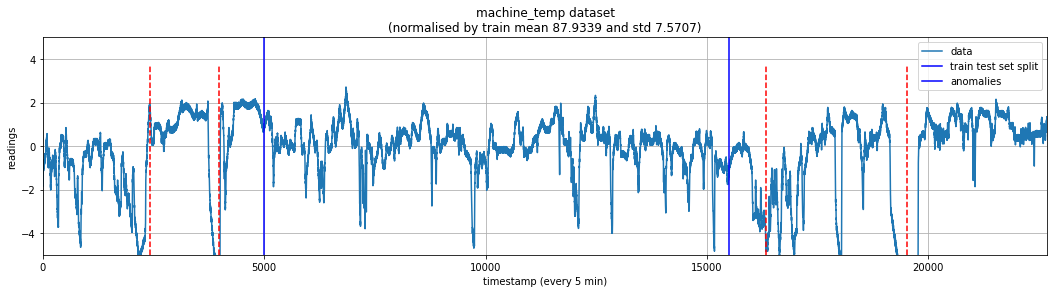

In [13]:
# create data generator
create_dirs([config['result_dir'], config['checkpoint_dir']])
data = DataGenerator(config)

Train model

In [15]:
BATCH_SIZE = 32

train_dataset = data.train_set_vae['data']
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dataset = data.val_set_vae['data']
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [38]:
# DEVICE = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [22]:
model_vae = VAEmodel(config)#.to(DEVICE)
optimizer = optim.Adam(model_vae.parameters(), lr=config['learning_rate_vae'])

EPOCH # 0
elbo tr 994.7583511404616
elbo te 424.32646083831787
EPOCH # 10
elbo tr 162.81020826528504
elbo te 175.19394493103027
EPOCH # 20
elbo tr 146.36537988031276
elbo te 148.28983616828918
EPOCH # 30
elbo tr 135.6063834440993
elbo te 137.4512655735016
EPOCH # 40
elbo tr 127.26483701113548
elbo te 130.72754430770874


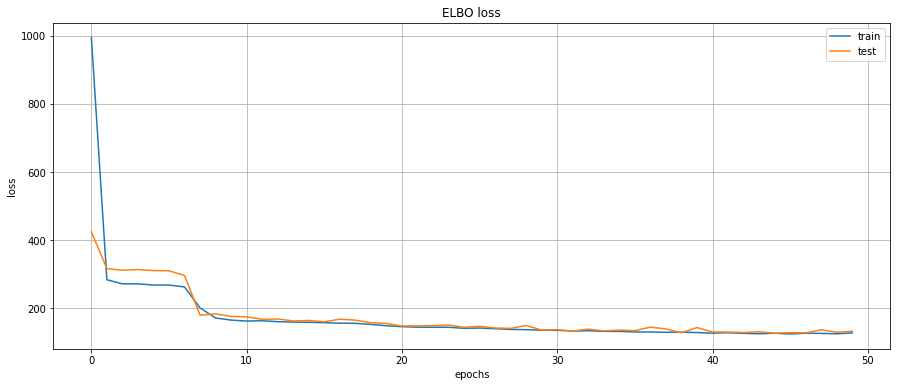

In [23]:
elbo_losses_tr, elbo_losses_te = [], []

for epoch in range(config['num_epochs_vae']):
    model_vae.train()
    elbo_loss_tr, elbo_loss_te = 0, 0
    for i, inputs in enumerate(train_loader):
        inputs = inputs.view(BATCH_SIZE, 1, -1, 1).float()
        # inputs = inputs.to(DEVICE)
        outputs, h, mu, gamma = model_vae(inputs)  

        elbo_loss, KL_loss, weighted_reconstruction_error_dataset, ls_reconstruction_error, sigma1, sigma_reg = model_vae.define_loss(inputs, 
                                                                                                                                      outputs, 
                                                                                                                                      mu, gamma)

        optimizer.zero_grad()
        elbo_loss.backward()
        optimizer.step()

        elbo_loss_tr += elbo_loss.item()
        
    elbo_losses_tr.append(elbo_loss_tr/len(train_loader))
    if epoch % 10 == 0:
      print('EPOCH #', epoch)
      print('elbo tr', elbo_loss_tr/len(train_loader))


    model_vae.eval()
    for i, inputs in enumerate(val_loader):
        inputs = inputs.view(BATCH_SIZE, 1, -1, 1).float()
        # avoid computing gradients of weights
        with torch.no_grad():
            outputs, h, mu, gamma = model_vae(inputs)
            elbo_loss, KL_loss, weighted_reconstruction_error_dataset, ls_reconstruction_error, sigma1, sigma_reg = model_vae.define_loss(inputs, 
                                                                                                                                          outputs, 
                                                                                                                                          mu, gamma)
        elbo_loss_te += elbo_loss.item()

    if epoch % 10 == 0:
        print('elbo te', elbo_loss_te/len(val_loader))
    elbo_losses_te.append(elbo_loss_te/len(val_loader))


fig = plt.figure(figsize=(15, 6))

plt.plot(elbo_losses_tr, label = 'train')
plt.plot(elbo_losses_te, label = 'test')
plt.title('ELBO loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc = 'upper right')
plt.grid()

plt.show()


In [24]:
class TimeSeriesDataSet(Dataset):
  
  def __init__(self, X, Y):
    self.X = X
    self.Y = Y
    if len(self.X) != len(self.Y):
      raise Exception("The length of X does not match the length of Y")

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    _x = self.X[index]
    _y = self.Y[index]

    return _x, _y

In [34]:
BATCH_SIZE = 32
lstm_model = LSTMmodel(config)
x_train, y_train, x_test, y_test, inputs_tr, inputs_te, mu_tr, mu_te, gamma_tr, gamma_te = lstm_model.produce_embeddings(config, model_vae, data)
train_loader_lstm = DataLoader(TimeSeriesDataSet(x_train, y_train), batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader_lstm = DataLoader(TimeSeriesDataSet(x_test, y_test), batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=config['learning_rate_lstm'])
loss_lstm = nn.MSELoss()

In [35]:
losses_lstm_tr, losses_lstm_te, elbo_losses_te = [], [], []

for epoch in range(config['num_epochs_lstm']):
    lstm_model.train()
    train_loss_lstm, test_loss_lstm, elbo_loss_te = 0, 0, 0
    for i, data_tr in enumerate(train_loader_lstm):
        
        inputs_lstm, labels = data_tr[0], data_tr[1]
        inputs_lstm = inputs_lstm.float()
        outputs_lstm, (hid_st, st_cell) = lstm_model(inputs_lstm)
        loss_l = loss_lstm(labels.float(), outputs_lstm.float()) 
        optimizer.zero_grad()
        loss_l.backward()
        optimizer_lstm.step()
        train_loss_lstm += loss_l.item()
        final_output = model_vae.decoder(hid_st)

    losses_lstm_tr.append(train_loss_lstm/len(train_loader_lstm))

    lstm_model.eval()
    for i, data_te in enumerate(test_loader_lstm):
        inputs_lstm, labels = data_te[0], data_te[1]
        inputs_lstm = inputs_lstm.float()
        with torch.no_grad():
            outputs_lstm, (hid_st, st_cell) = lstm_model(inputs_lstm)

            loss_l = loss_lstm(labels, outputs_lstm)
        
            final_output = model_vae.decoder(hid_st)
            elbo_loss, KL_loss, weighted_reconstruction_error_dataset, ls_reconstruction_error, sigma, sigma_rec = model_vae.define_loss(inputs_te[(i+1) * BATCH_SIZE: (i+2) * BATCH_SIZE][0][:], 
                                                                                                                                     final_output, 
                                                                                                                                     mu_te[(i+1) * BATCH_SIZE: (i+2) * BATCH_SIZE][0][:], 
                                                                                                                                     gamma_te[(i+1) * BATCH_SIZE: (i+2) * BATCH_SIZE][0][:])
        test_loss_lstm += loss_l.item()
        elbo_loss_te += elbo_loss.item()

    losses_lstm_te.append(test_loss_lstm/len(test_loader_lstm))
    elbo_losses_te.append(elbo_loss_te/len(train_loader_lstm))  

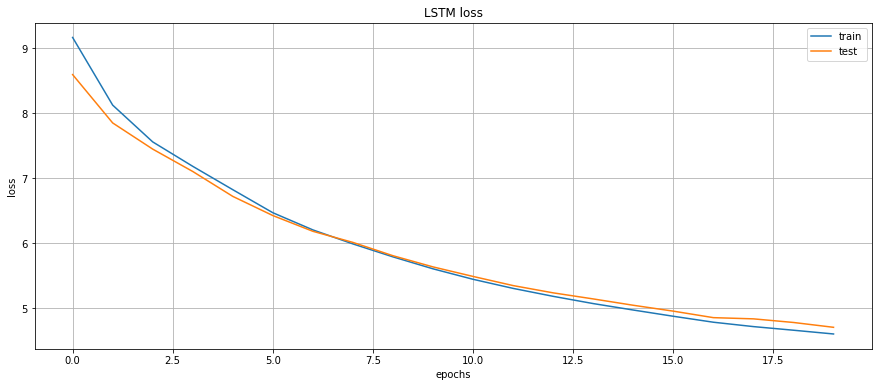

In [37]:
fig = plt.figure(figsize=(15, 6))


plt.plot(losses_lstm_tr, label = 'train')
plt.plot(losses_lstm_te, label = 'test')
plt.title('LSTM loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc = 'upper right')
plt.grid()

plt.show()

# detection of anomalies

In [38]:
save_dir = '../datasets/NAB-known-anomaly/'
dataset = config['dataset']
filename = '{}.npz'.format(dataset)
result = dict(np.load(save_dir+filename, allow_pickle=True))
if dataset == 'machine_temp':
    result['test'] = result['test'][0]
    result['idx_anomaly_test'] = result['idx_anomaly_test'][0]
    result['t_test'] = result['t_test'][0]

In [39]:
def slice_rolling_windows_and_sequences(config, time_seq):
    n_sample = len(time_seq)
    print("The given sequence has {} samples".format(n_sample))
    n_vae_win = n_sample - config['l_win'] + 1
    rolling_windows = np.zeros((n_vae_win, config['l_win']))
    for i in range(n_vae_win):
        rolling_windows[i] = time_seq[i:i + config['l_win']]
    sample_m = np.mean(rolling_windows, axis=1)
    sample_std = np.std(rolling_windows, axis=1)
    n_lstm_seq = n_sample - config['l_seq']*config['l_win']+1
    lstm_seq = np.zeros((n_lstm_seq, config['l_seq'], config['l_win']))
    for i in range(n_lstm_seq):
        cur_seq = time_seq[i:i+config['l_seq']*config['l_win']]
        for j in range(config['l_seq']):
            lstm_seq[i,j] = cur_seq[config['l_win']*j:config['l_win']*(j+1)]
    
    return rolling_windows, lstm_seq, sample_m, sample_std



In [40]:
test_windows, test_seq, test_sample_m, test_sample_std = slice_rolling_windows_and_sequences(config, result['test'])
test_windows = np.expand_dims(test_windows, -1)
test_seq = np.expand_dims(test_seq, -1)
print(test_windows.shape)
print(test_seq.shape)

The given sequence has 5000 samples
(4953, 48, 1)
(4425, 12, 48, 1)


In [42]:
# Evaluate ELBO and LSTM prediction error on the validation set
def evaluate_vae_anomaly_metrics_for_a_window(test_win, model_f_vae):

    model_f_vae.eval()
    outputs, h, mu, gamma = model_f_vae(torch.from_numpy(np.expand_dims(test_win, 0)))  

    # VAE reconstruction error
    recons_win_vae = np.squeeze(outputs)
    recons_win_vae = recons_win_vae.detach().numpy()
    test_vae_recons_error = np.sum(np.square(recons_win_vae - test_win))
    # VAE latent embedding likelihood
    vae_code_mean, vae_code_std = mu.detach().numpy(), gamma.detach().numpy()
    test_vae_kl = 0.5 * (np.sum(np.square(vae_code_mean)) + \
                            np.sum(np.square(vae_code_std)) - \
                            np.sum(np.log(np.square(vae_code_std))) - config['code_size'])
    test_vae_kl = np.mean(test_vae_kl)

    # VAE ELBO loss
    sigma2 = 0.0005
    input_dims = model_f_vae.input_dims
    sigma_regularisor = input_dims/2. * np.log(sigma2) + input_dims * np.pi
    test_vae_elbo = test_vae_recons_error/sigma2 + test_vae_kl + sigma_regularisor
    return test_vae_recons_error, test_vae_kl, test_vae_elbo

def evaluate_lstm_anomaly_metric_for_a_seq(test_seq, model_f_vae, model_f_lstm):
    model_f_vae.eval()
    outputs, h, mu, gamma = model_f_vae.encoder(torch.from_numpy(test_seq))
    vae_embedding = np.squeeze(mu.detach().numpy())
    for_LSTM = np.expand_dims(vae_embedding[:config['l_seq']-1], 0)  
    model_f_lstm.eval()
    out, (hid, mem) = model_f_lstm(torch.from_numpy(for_LSTM))

    lstm_embedding = np.squeeze(hid.detach().numpy())
    lstm_embedding_error = np.sum(np.square(vae_embedding[1:] - lstm_embedding))  
    
    # LSTM prediction error
    recons_win_lstm = np.squeeze(model_f_vae.decoder(torch.from_numpy(lstm_embedding)))
    lstm_recons_error = np.sum(np.square(recons_win_lstm.detach().numpy() - np.squeeze(test_seq[1:])))
    return lstm_recons_error, lstm_embedding_error



In [43]:
n_val_vae = data.val_set_vae['data'].shape[0]
n_val_lstm = data.val_set_lstm['data'].shape[0]

val_vae_recons_error = np.zeros(n_val_vae)
val_vae_kl_error = np.zeros(n_val_vae)
val_vae_elbo_loss = np.zeros(n_val_vae)
for i in range(n_val_vae):
    val_vae_recons_error[i], val_vae_kl_error[i], val_vae_elbo_loss[i] = evaluate_vae_anomaly_metrics_for_a_window(data.val_set_vae['data'][i], model_vae)

val_lstm_recons_error, val_lstm_embedding_error = np.zeros(n_val_lstm), np.zeros(n_val_lstm)
for i in range(n_val_lstm):
    # print(data.val_set_lstm['data'][i].shape)
    val_lstm_recons_error[i], val_lstm_embedding_error[i] = evaluate_lstm_anomaly_metric_for_a_seq(data.val_set_lstm['data'][i], model_vae, lstm_model)

print('val_vae_recons_error', val_vae_recons_error)
print('val_vae_kl_error', val_vae_kl_error)
print('val_vae_elbo_loss', val_vae_elbo_loss)
print('val_lstm_recons_error', val_lstm_recons_error[:10])
print('val_lstm_embedding_error', val_lstm_embedding_error[:10])

val_vae_recons_error [144.01558237 158.04249286 114.41418755 ... 365.53854269 567.09868906
 348.63229176]
val_vae_kl_error [47.05350113 46.65901184 47.41247559 ... 40.71796417 46.08135223
 48.15751266]
val_vae_elbo_loss [ 288046.59303576  316100.01951647  228844.16237359 ...  731086.17813741
 1134211.83425984  697281.11582984]
val_lstm_recons_error [ 451.64404422  517.41228441  658.81579848  520.88395106  110.03617232
  138.56852427  433.85377401  324.10759111 1818.85897329 2262.10399363]
val_lstm_embedding_error [ 620.43786621  678.21081543  840.27380371 1019.12854004  334.91186523
  349.77838135  781.7611084   384.01333618 1104.2791748  1204.05822754]


In [44]:
from scipy.stats import norm
def plot_histogram(test_anomaly_metric, n_bins, title, mean=None, std=None, xlim=None):
    # print(test_anomaly_metric)
    test_anomaly_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    # print(test_anomaly_list)
    his = plt.hist(test_anomaly_list, bins=n_bins, density=True)
    if mean is None and std is None:
        mean = np.mean(test_anomaly_list)
        std = np.std(test_anomaly_list)
        legend_label = None
    else:
        legend_label = 1
    x_axis = np.arange(mean-5*std, mean+5*std, std/100)
    plt.plot(x_axis, norm.pdf(x_axis,mean,std))
    plt.title(title)
    plt.xlabel('anomaly score value')
    plt.ylabel('probability density')
    if xlim is not None:
        plt.xlim(0, xlim)
    else:
        plt.xlim(0, np.amax(test_anomaly_list))
    if legend_label is None:
        plt.legend(('Fitted Gaussian', 'histogram'))
    else:
        plt.legend(('normal data distribution','test data distribution (contain anomalies)'))
    plt.show()
    threshold_25 = np.percentile(test_anomaly_list, 25)
    threshold_75 = np.percentile(test_anomaly_list, 75)
    threshold_1 = np.percentile(test_anomaly_list, 99)
    idx_large_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold_1))
    print("25% percentile: {}".format(threshold_25))
    print("75% percentile: {}".format(threshold_75))
    print("These windows scored the top 1% of anomaly metric ({}): \n{}".format(threshold_1, idx_large_error))
    return mean, std

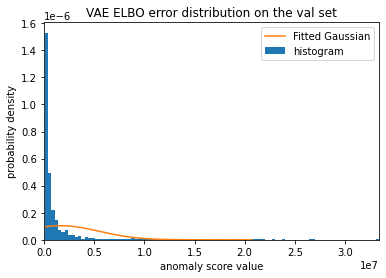

25% percentile: 150630.41372558987
75% percentile: 1038317.1108872154
These windows scored the top 1% of anomaly metric (20800933.644973956): 
[ 468  469  470  779  781  782 1007 1012 1013 1014 1015]


In [45]:
# Histogram of VAE ELBO loss - validation set
vae_elbo_m, vae_elbo_std = plot_histogram(val_vae_elbo_loss, 100, 
                                          'VAE ELBO error distribution on the val set', 
                                          mean=None, std=None, xlim=None)

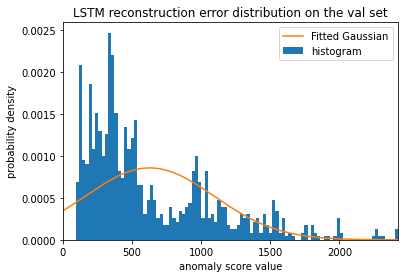

25% percentile: 291.6842889252157
75% percentile: 941.8855771756104
These windows scored the top 1% of anomaly metric (2006.5907190673483): 
[  9  49 118 218 261 491 621 679 851 984]


In [46]:
# Histogram of LSTM reconstruction error - validation set 
#  --> to decide the anomaly detection threshold
lstm_recons_m, lstm_recons_std = plot_histogram(val_lstm_recons_error, 100,  
                                              'LSTM reconstruction error distribution on the val set', 
                                              mean=None, std=None, xlim=None)

In [48]:
# Evaluate the anomaly metrics on the test windows and sequences
n_test_lstm = test_seq.shape[0]

test_lstm_recons_error, test_lstm_embedding_error = np.zeros(n_test_lstm), np.zeros(n_test_lstm)
for i in range(n_test_lstm):
    test_lstm_recons_error[i], test_lstm_embedding_error[i] = evaluate_lstm_anomaly_metric_for_a_seq(test_seq[i], model_vae, lstm_model)
print("All windows' reconstruction error is computed.")
print("The total number of windows is {}".format(len(test_lstm_recons_error)))

All windows' reconstruction error is computed.
The total number of windows is 4425


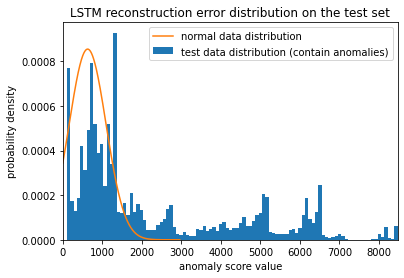

25% percentile: 736.906316393875
75% percentile: 3710.39889004787
These windows scored the top 1% of anomaly metric (8158.201593238746): 
[3426 3427 3428 3429 3430 3431 3432 3433 3434 3435 3437 3438 3439 3440
 3441 3442 3443 3444 3445 3599 3600 3601 3602 3603 3604 3605 3606 3607
 3608 3609 3610 3611 3629 3630 3631 3632 3633 3634 3635 3636 3637 3638
 3639 3640 3641]


In [49]:
# Histogram of LSTM reconstruction error - test set 
#  --> to detect anomaly now
_, _ = plot_histogram(test_lstm_recons_error, 100,
                      'LSTM reconstruction error distribution on the test set', 
                      mean=lstm_recons_m, std=lstm_recons_std, xlim=None)

In [62]:
# Produce the ground truth anomaly indices 

idx_anomaly_test = result['idx_anomaly_test'] 
print(idx_anomaly_test)   
anomaly_index_lstm = []
test_labels_lstm = np.zeros(n_test_lstm)
for i in range(len(idx_anomaly_test)):
    idx_start = idx_anomaly_test[i]-(config['l_win']*config['l_seq']-1)
    # print(idx_start)
    idx_end = idx_anomaly_test[i]+1
    # print(idx_end)
    if idx_start < 0:
        idx_start = 0
    if idx_end > n_test_lstm:
        idx_end = n_test_lstm
    anomaly_index_lstm.append(np.arange(idx_start,idx_end))
    test_labels_lstm[idx_start:idx_end] = 1
    
print(test_labels_lstm.shape)

[2410 3987]
(4425,)


In [63]:
def return_anomaly_idx_by_threshold(test_anomaly_metric, threshold):
    # print(test_anomaly_metric)
    test_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    # print(test_list)
    idx_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold))
    # print('index error', idx_error.shape)
    if len(idx_error.shape) == 0:
        idx_error = np.expand_dims(idx_error, 0)
        # print('index error after expand dims', idx_error.shape)
    return list(idx_error)

In [64]:
def augment_detected_idx(idx_detected_anomaly, anomaly_index):
    n_anomaly = len(anomaly_index)
    idx_detected_anomaly_extended = list(idx_detected_anomaly)
    # print('idx_detected_anomaly_extended', len(idx_detected_anomaly_extended))
    for i in range(n_anomaly):
        #print(idx_detected_anomaly)
        for j in idx_detected_anomaly:
            if j in anomaly_index[i]:
                in_original_detection = set(idx_detected_anomaly_extended)
                # print('in_original_detection', in_original_detection)
                currect_anomaly_win = set(anomaly_index[i])
                # print('currect_anomaly_win', currect_anomaly_win)
                idx_detected_anomaly_extended = idx_detected_anomaly_extended + list(currect_anomaly_win - in_original_detection)
                #print(j)
                break
                
    return list(np.sort(idx_detected_anomaly_extended))

In [65]:
def count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels):
    n_TP = 0
    n_FP = 0
    n_detection = len(idx_detected_anomaly)
    for i in range(n_detection):
        if test_labels[idx_detected_anomaly[i]] == 1:
            n_TP = n_TP + 1
        else:
            n_FP = n_FP + 1
    
    idx_undetected = list(set(np.arange(len(test_labels)))- set(idx_detected_anomaly))
    n_FN = 0
    for i in idx_undetected:
        if test_labels[i] == 1:
            n_FN = n_FN + 1
    
    return n_TP, n_FP, n_FN

In [66]:
def compute_precision_and_recall(idx_detected_anomaly, anomaly_index, test_labels):
    # compute true positive
    n_TP, n_FP, n_FN = count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels)
    
    if n_TP + n_FP == 0:
        precision = 1
    else:
        precision = n_TP / (n_TP + n_FP)
    recall = n_TP / (n_TP + n_FN)
    if precision + recall == 0:
        F1 = 0
    else:
        F1 = 2* (precision * recall)/(precision + recall)
    
    return precision, recall, F1, n_TP, n_FP, n_FN

In [67]:
n_threshold = 200
precision = np.zeros(n_threshold)
recall = np.zeros(n_threshold)
F1 = np.zeros(n_threshold)
precision_aug = np.zeros(n_threshold)
recall_aug = np.zeros(n_threshold)
F1_aug = np.zeros(n_threshold)
i = 0
threshold_list = np.linspace(np.amin(test_lstm_recons_error), np.amax(test_lstm_recons_error), n_threshold, endpoint=True)
threshold_list = np.flip(threshold_list)
for threshold in threshold_list:
    #print(threshold_list[i])
    idx_detection_lstm = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
    precision[i], recall[i], F1[i], _, _, _ = compute_precision_and_recall(idx_detection_lstm, 
                                                                           anomaly_index_lstm, 
                                                                           test_labels_lstm)
    # augment the detection using the ground truth labels
    # a method to discount the factor one anomaly appears in multiple consecutive windows
    idx_detection_lstm_augmented = augment_detected_idx(idx_detection_lstm, anomaly_index_lstm)
    precision_aug[i], recall_aug[i], F1_aug[i], _, _, _ = compute_precision_and_recall(idx_detection_lstm_augmented, 
                                                                                       anomaly_index_lstm, 
                                                                                       test_labels_lstm)
    i = i + 1
    # print(precision, recall, F1)

In [68]:
print("Best F1 score is {}".format(np.amax(F1)))
idx_best_threshold = np.squeeze(np.argwhere(F1 == np.amax(F1)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision[idx_best_threshold], recall[idx_best_threshold]))
average_precision = np.sum(precision[1:] * (recall[1:] - recall[:-1]))
print("Average precision is {}".format(average_precision))

print("\nAugmented detection:")
print("Best F1 score is {}".format(np.amax(F1_aug)))
idx_best_threshold = np.squeeze(np.argwhere(F1_aug == np.amax(F1_aug)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision_aug[idx_best_threshold], 
                                                                recall_aug[idx_best_threshold]))

average_precision_aug = np.sum(precision_aug[1:] * (recall_aug[1:] - recall_aug[:-1]))
print("Average precision is {}".format(average_precision_aug))

Best F1 score is 0.6884422110552764
Best threshold is 2837.819366427986
At this threshold, precision is 0.6650485436893204, recall is 0.7135416666666666
Average precision is 0.7536272966447406

Augmented detection:
Best F1 score is 1.0
Best threshold is [7169.39350228 7127.33938446 7085.28526663 7043.23114881 7001.17703098
 6959.12291316 6917.06879534 6875.01467751 6832.96055969 6790.90644187
 6748.85232404 6706.79820622 6664.74408839 6622.68997057 6580.63585275
 6538.58173492 6496.5276171  6454.47349928 6412.41938145 6370.36526363
 6328.3111458 ]
At this threshold, precision is [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.], recall is [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Average precision is 1.0


In [70]:
# Now select a threshold
threshold = 3000

print("Threshold is {}".format(threshold))
idx_detection = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index_lstm)
precision, recall, F1, n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index_lstm, 
                                                                       test_labels_lstm)
print("\nPR evaluation using augmented detection:")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

Threshold is 3000

PR evaluation using augmented detection:
Precision: 0.7389352148813342
Recall: 1.0
F1: 0.849870896348211
TP: 1152
FP: 407
FN: 0


In [71]:
def slice_detected_indices_into_seq(idx_detection, interval):
    detected_seq = []
    i = 0
    while i < len(idx_detection):
        if i == 0:
            cur_seq = [idx_detection[i]]
            i = i + 1
        else:
            if idx_detection[i] - idx_detection[i-1] > interval:
                detected_seq.append(cur_seq)
                cur_seq = [idx_detection[i]]
            else:
                cur_seq.append(idx_detection[i])
                if i == len(idx_detection) - 1:
                    detected_seq.append(cur_seq)
            i = i + 1
    
    print("Detected {} sequences".format(len(detected_seq)))
    return detected_seq

In [72]:
def plot_detected_anomalies(idx_detection, interval, dataset, result, detection_method, augmented_flag=1, y_scale=5, y_lim=None):
    detected_seq = slice_detected_indices_into_seq(idx_detection, interval=interval)
    t_test = result['t_test']
    test = result['test']
    idx_anomaly_test = result['idx_anomaly_test']
        
    # plot detected sequences
    fig, axs = plt.subplots(1, 1, figsize=(18, 5), edgecolor='k')
    fig.subplots_adjust(hspace=.4, wspace=.4)
    axs.plot(t_test, test)
    for j in range(len(idx_anomaly_test)):
        if j == 0:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--', label='true anomalies')
        else:
            axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--')
        
    for i in range(len(detected_seq)):
        for j in detected_seq[i]:
            if j == detected_seq[0][0]:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-', label='detected anomalies')
            else:
                axs.plot((j+interval*2) * np.ones(20), np.linspace(-y_scale, -0.8*y_scale, 20), 'g-')
    
    for j in range(len(idx_anomaly_test)):
        axs.plot(idx_anomaly_test[j] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'r--')

    for i in range(len(detected_seq)):
        interval_x = np.asarray([detected_seq[i][0], detected_seq[i][-1]+interval*2])
        interval_y = np.asarray([y_scale,y_scale])
        if i == 0:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y', label='detected anomaly windows')
        else:
            axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
        interval_y = np.asarray([-y_scale,-y_scale])
        axs.fill_between(interval_x, interval_y, alpha=0.2, color='y')
    axs.grid(True)
    axs.set_xlim(0, len(t_test))
    if y_lim is None:
        axs.set_ylim(-y_scale, y_scale)
    else:
        axs.set_ylim(-y_scale, y_lim)
    axs.set_xlabel("timestamp (every {})".format(result['t_unit']))
    axs.set_ylabel("normalised readings")
    axs.set_title("{} dataset test sequence\n(normalised by train mean {:.4f} and std {:.4f})\n Detection method: {}".format(dataset, 
                                                                                        result['train_m'], 
                                                                                        result['train_std'],
                                                                                        detection_method))
    axs.legend()
    savefig(config['result_dir']+'detected_anomalies_{}_aug_{}.pdf'.format(detection_method, augmented_flag))

Detected 2 sequences


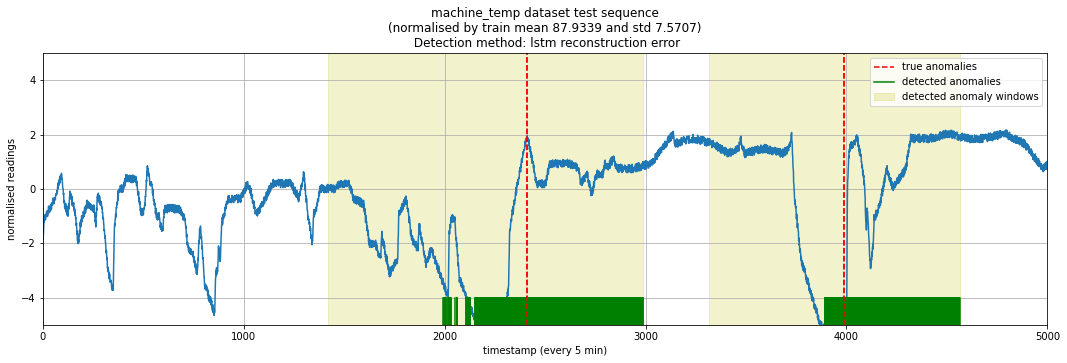

In [73]:
plot_detected_anomalies(idx_detection_augmented, 
                        interval=config['l_win']*config['l_seq']/2, 
                        dataset=dataset, 
                        result=result, 
                        detection_method='lstm reconstruction error',
                        augmented_flag=1,
                        y_scale=5,
                        y_lim=5)

# Check using artificial data


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import json


class TSGenerator:
    def __init__(self, TSconfig):
        self.number_of_observations = TSconfig["number_of_observations"]

    def base_TS(self, TSconfig):
        base = TSconfig["base"]
        var = TSconfig["variance"]

        self.time_series["data"] = self.time_series["data"].apply(lambda obs: obs + np.random.normal(base, var, 1)[0])        

    def add_trend(self, TSconfig):
        slope = TSconfig["slope"]
        self.time_series["index"] = self.time_series.index
        self.time_series["trend"] = self.time_series["index"].apply(lambda obs: slope * obs)
        self.time_series["data"] = self.time_series["data"] + self.time_series["trend"]

        self.time_series.drop("trend", inplace=True, axis=1)
        self.time_series.drop("index", inplace=True, axis=1)

    def add_season(self, TSconfig):
        period = TSconfig["period"]
        height = TSconfig["height"]

        self.time_series["index"] = self.time_series.index
        # self.time_series["season"] = self.time_series["index"].apply(lambda obs: height * math.sin((2 * math.pi) / period))
        self.time_series["season"] = self.time_series["index"].apply(lambda obs: np.sin(2*np.pi*period * (obs/self.time_series.shape[0]))) # [math.sin(2*math.pi*i/T) for i in x_normal]
        # plt.plot(self.time_series["season1"])
        # self.time_series["season"] = self.time_series["sin"].apply(lambda obs: obs if obs > 0 else 0)
        self.time_series["data"] = self.time_series["data"] * self.time_series["season"]

        self.time_series.drop("season", inplace=True, axis=1)
        self.time_series.drop("index", inplace=True, axis=1)

    def add_anomalies(self, TSconfig):

        anomalies = TSconfig
        for anomaly in anomalies:
            position = anomaly["position"]
            coeficient = anomaly["coef"]
            self.time_series["data"].iloc[position] = (self.time_series["data"].iloc[position] * coeficient)

    def add_jumps(self, TSconfig):

        breaks = TSconfig
        for record in breaks:
            start = record["from"]
            end = record["to"]
            value = record["value"]
            self.time_series["data"].iloc[start : end + 1] = (self.time_series["data"] + value)

    def add_timestamp(self, TSconfig):
        start = TSconfig["start"]
        step = TSconfig["step"]

        self.time_series["index"] = self.time_series.index
        self.time_series["timestamp"] = self.time_series["index"].apply(lambda obs: start + obs * step)

        self.time_series.set_index("timestamp", inplace=True)

        self.time_series.drop("index", inplace=True, axis=1)

    def plot(self):
        self.time_series.plot()
        plt.show()

    def to_csv(self, file_name):
        self.time_series.to_csv(file_name, sep=",", index=True)
        print(("Time series " + file_name + " saved."))

    def generate(self, TSconfig):

        self.time_series = pd.DataFrame({"data": np.zeros(self.number_of_observations)})

        for key in TSconfig:
            if key == "base_line":
                self.base_TS(TSconfig=TSconfig[key])
            elif key == "trend":
                self.add_trend(TSconfig=TSconfig[key])
            elif key == "season":
                self.add_season(TSconfig=TSconfig[key])
            elif key == "annomalies":
                self.add_anomalies(TSconfig=TSconfig[key])
            elif key == "breaks":
                self.add_jumps(TSconfig=TSconfig[key])
            elif key == "meta":
                pass
            elif key == "timestamps":
                self.add_timestamp(TSconfig=TSconfig[key])
            else:
                raise ValueError("A key " + key + " is not defined!")

    def get(self):
        return self.time_series

    def get_data(self):
        _ts = self.time_series.copy()

        days = len(_ts.values.flatten())
        calendar = pd.date_range(start="20000101", freq="B", periods=days)
        time_series = pd.Series(data=_ts.values.flatten(), index=calendar)

        return time_series

In [47]:
def prep_data(dataset, config_ts):
    
    idx_anomaly = []
    for lib in config_ts['annomalies']:
        for key, value in lib.items():
            if key == 'position':
                idx_anomaly.append(value)
    t_unit = 'buisness_day'
    t = []
    readings = []
    i = 0
    
    for index, row in dataset.iterrows():
        if i > 0:
            t.append(i)
            readings.append(float(row))
        i = i + 1
    t = np.asarray(t)
    readings = np.asarray(readings)
    
    return t, t_unit, readings, idx_anomaly

In [48]:
def process_and_save_specified_dataset(config_ts, dataset, idx_split, y_scale=5, save_file=False):
    t, t_unit, readings, idx_anomaly = prep_data(dataset, config_ts)
    
    # split into training and test sets
    training = readings[idx_split[0]:idx_split[1]]
    t_train = t[idx_split[0]:idx_split[1]]
    
    # normalise by training mean and std 
    train_m = np.mean(training)
    train_std = np.std(training)
    print("\nTraining set mean is {}".format(train_m))
    print("Training set std is {}".format(train_std))
    readings_normalised = (readings - train_m) / train_std
    
    training = readings_normalised[idx_split[0]:idx_split[1]]
    test = readings_normalised[idx_split[1]:]
    t_test = t[idx_split[1]:] - idx_split[1]
    idx_anomaly_test = np.asarray(idx_anomaly) - idx_split[1]
    idx_anomaly_f_test = np.array(idx_anomaly_test)
    print("Anomaly indices in the test set are {}".format(idx_anomaly_f_test))

    data = {}
    data['t'] = t
    data['t_unit'] = t_unit
    data['readings'] = readings
    data['idx_anomaly'] = idx_anomaly
    data['idx_split'] = idx_split
    data['training'] = training
    data['test'] = test
    data['train_m'] = train_m
    data['train_std'] = train_std
    data['t_train'] = t_train
    data['t_test'] = t_test
    data['idx_anomaly_test'] = idx_anomaly_f_test
    
    # plot the whole normalised sequence
    fig, axs = plt.subplots(1, 1, figsize=(18, 4), edgecolor='k')
    fig.subplots_adjust(hspace=.4, wspace=.4)
    axs.plot(t, readings_normalised)
    if idx_split[0] == 0:
        axs.plot(idx_split[1]*np.ones(20), np.linspace(-y_scale,y_scale,20), 'b--')
    else:
        for i in range(2):
            axs.plot(idx_split[i]*np.ones(20), np.linspace(-y_scale,y_scale,20), 'b--')
    for j in range(len(idx_anomaly)):
        axs.plot(idx_anomaly[j]*np.ones(20), np.linspace(-y_scale,y_scale,20), 'r--')
    axs.grid(True)
    axs.set_xlim(0, len(t))
    axs.set_ylim(-y_scale, y_scale)
    axs.set_xlabel("timestamp (every {})".format(t_unit))
    axs.set_ylabel("normalised readings")
    axs.set_title("{} dataset\n(normalised by train mean {:.2f} and std {:.2f})".format(dataset, train_m, train_std))
    axs.legend(('data', 'train test set split', 'anomalies'))
    
    return t, readings_normalised, data

In [49]:
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pyplot import savefig
import os
import random

class ArtBaseDataGenerator:
  def __init__(self, config):
    self.config = config

  # separate training and val sets
  def separate_train_and_val_set(self, n_win):
    n_train = int(np.floor((n_win * 0.9)))
    n_val = n_win - n_train
    idx_train = random.sample(range(n_win), n_train)
    idx_val = list(set(idx_train) ^ set(range(n_win)))
    # print('idx_train, idx_val, n_train, n_val', len(idx_train), len(idx_val), n_train, n_val)
    return idx_train, idx_val, n_train, n_val


class ArtDataGenerator(ArtBaseDataGenerator):
  def __init__(self, dataset, config):
    super(ArtDataGenerator, self).__init__(config)
    # load data here: generate 3 state variables: train_set, val_set and test_set
    self.load_NAB_dataset(dataset, self.config['y_scale'])

  def load_NAB_dataset(self, dataset, y_scale=6):
    data = dataset
    # normalise the dataset by training set mean and std
    train_m = data['train_m']
    train_std = data['train_std']
    readings_normalised = (data['readings'] - train_m) / train_std

    # plot normalised data
    fig, axs = plt.subplots(1, 1, figsize=(18, 4), edgecolor='k')
    fig.subplots_adjust(hspace=.4, wspace=.4)
    axs.plot(data['t'], readings_normalised)
    if data['idx_split'][0] == 0:
      axs.plot(data['idx_split'][1] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'b-')
    else:
      for i in range(2):
        axs.plot(data['idx_split'][i] * np.ones(20), np.linspace(-y_scale, y_scale, 20), 'b-')
    # axs.plot(*np.ones(20), np.linspace(-y_scale, y_scale, 20), 'b--')
    for j in range(len(data['idx_anomaly'])):
      axs.plot(data['idx_anomaly'][j] * np.ones(20), np.linspace(-y_scale, 0.75 * y_scale, 20), 'r--')
    axs.grid(True)
    axs.set_xlim(0, len(data['t']))
    axs.set_ylim(-y_scale, y_scale)
    axs.set_xlabel("timestamp (every {})".format(data['t_unit']))
    axs.set_ylabel("readings")
    axs.set_title("{} dataset\n(normalised by train mean {:.4f} and std {:.4f})".format(dataset, train_m, train_std))
    axs.legend(('data', 'train test set split', 'anomalies'))

    # slice training set into rolling windows
    n_train_sample = len(data['training'])
    # print('n_train_sample', n_train_sample)
    n_train_vae = n_train_sample - self.config['l_win'] + 1
    # print('n_train_vae', n_train_vae)
    rolling_windows = np.zeros((n_train_vae, self.config['l_win']))
    # print('rolling_windows', len(rolling_windows))
    for i in range(n_train_sample - self.config['l_win'] + 1):
      rolling_windows[i] = data['training'][i:i + self.config['l_win']]

    # create VAE training and validation set
    idx_train, idx_val, self.n_train_vae, self.n_val_vae = self.separate_train_and_val_set(n_train_vae)
    self.train_set_vae = dict(data=np.expand_dims(rolling_windows[idx_train], -1))

    # print('train_set_vae', self.train_set_vae['data'][:5])
    self.val_set_vae = dict(data=np.expand_dims(rolling_windows[idx_val], -1))
    print('val_set_vae', self.val_set_vae['data'].shape)
    self.test_set_vae = dict(data=np.expand_dims(rolling_windows[idx_val[:self.config['batch_size']]], -1))
    print('test_set_vae', self.test_set_vae['data'].shape)

    # create LSTM training and validation set
    for k in range(self.config['l_win']):
      n_not_overlap_wins = (n_train_sample - k) // self.config['l_win']
      # print('n_not_overlap_wins', n_not_overlap_wins)
      n_train_lstm = n_not_overlap_wins - self.config['l_seq'] + 1
      # print('n_train_lstm', n_train_lstm)
      cur_lstm_seq = np.zeros((n_train_lstm, self.config['l_seq'], self.config['l_win']))
      # print('cur_lstm_seq', cur_lstm_seq)
      for i in range(n_train_lstm):
        cur_seq = np.zeros((self.config['l_seq'], self.config['l_win']))
        for j in range(self.config['l_seq']):
          # print(k,i,j)
          cur_seq[j] = data['training'][k + self.config['l_win'] * (j + i): k + self.config['l_win'] * (j + i + 1)]
          # print('cur_seq[j]', cur_seq[j])
        cur_lstm_seq[i] = cur_seq
      if k == 0:
        lstm_seq = cur_lstm_seq
      else:
        lstm_seq = np.concatenate((lstm_seq, cur_lstm_seq), axis=0)

    n_train_lstm = lstm_seq.shape[0]
    idx_train, idx_val, self.n_train_lstm, self.n_val_lstm = self.separate_train_and_val_set(n_train_lstm)
    # print(n_train_lstm, self.n_train_lstm)
    self.train_set_lstm = dict(data=np.expand_dims(lstm_seq[idx_train], -1))
    # print('train_set_lstm', self.train_set_lstm['data'][:5])
    self.val_set_lstm = dict(data=np.expand_dims(lstm_seq[idx_val], -1))
    # print('val_set_lstm', self.val_set_lstm['data'][:5])

  def plot_time_series(self, data, time, data_list):
    fig, axs = plt.subplots(1, 4, figsize=(18, 2.5), edgecolor='k')
    fig.subplots_adjust(hspace=.8, wspace=.4)
    axs = axs.ravel()
    for i in range(4):
      axs[i].plot(time / 60., data[:, i])
      axs[i].set_title(data_list[i])
      axs[i].set_xlabel('time (h)')
      axs[i].set_xlim((np.amin(time) / 60., np.amax(time) / 60.))

In [86]:
config_ts = {
      "meta": {
        "path": "./timeseries/",
        "time_series_name": "11-base-trend-season-anomaly-regular",
        "number_of_observations": 10000
      },
      "base_line": {
        "base": 1000,
        "variance": 200
      },
      "trend": {
        "slope": 0.5
      },
      # "season": {
      #   "period": 5,
      #   "height": 4.9
      # },
      "annomalies": [
        {
          "position": 8150,
          "coef": 1
        },
        {
          "position": 9125,
          "coef": 1
        },
      ],
      # "timestamps": {
      #   "start": 0,
      #   "step": 10
      # }, 
      "breaks": [{'from': 7800, 'to': 8500, 'value': 300},
                 {'from': 7900, 'to': 8400, 'value': 400},
                 {'from': 8000, 'to': 8300, 'value': 500},
                 {'from': 8100, 'to': 8200, 'value': 600},
                 {'from': 8150, 'to': 8150, 'value': 800},
                 {'from': 9000, 'to': 9250, 'value': -500},
                 {'from': 9050, 'to': 9200, 'value': -700},
                 {'from': 9100, 'to': 9150, 'value': -900},
                 {'from': 9125, 'to': 9125, 'value': -1100}]
        }

In [87]:
series = []
generator = TSGenerator(config_ts["meta"])
generator.generate(config_ts)
ts = generator.get_data()
ts.name = 1
series.append(ts)
prices_df = pd.DataFrame(series).T
prices_df.index.name = "date"


Training set mean is 2748.1793806721107
Training set std is 1028.8515636498691
Anomaly indices in the test set are [1150 2125]


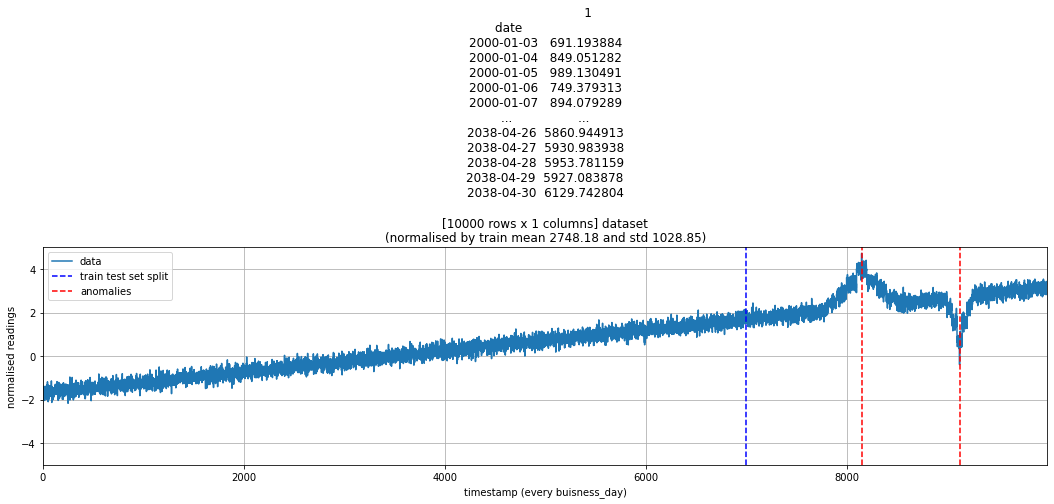

In [88]:
t, readings_normalised, dataset = process_and_save_specified_dataset(config_ts, prices_df, (0,7000), save_file=True)

val_set_vae (696, 48, 1)
test_set_vae (32, 48, 1)


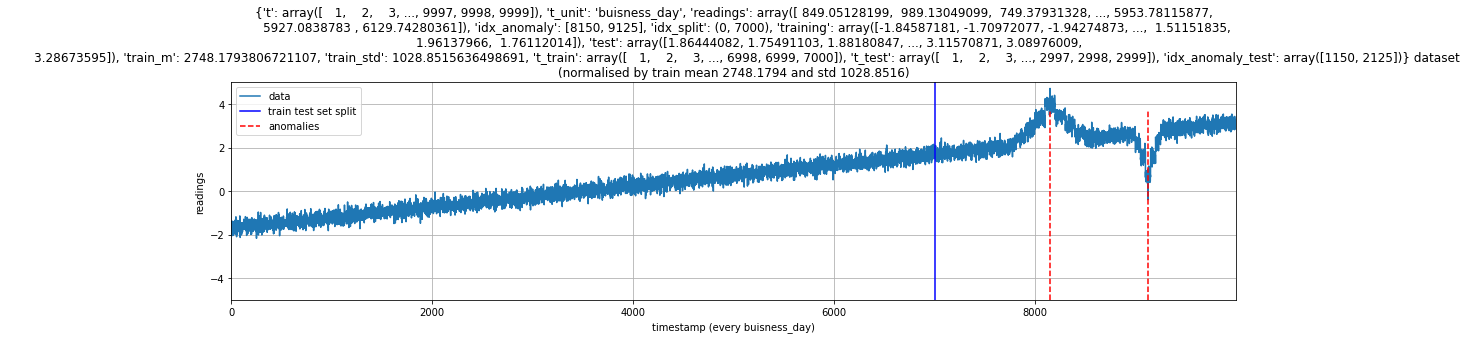

In [89]:
data_art = ArtDataGenerator(dataset, config)

In [130]:
BATCH_SIZE = 32

train_dataset_art = data_art.train_set_vae['data']
train_loader_art = DataLoader(train_dataset_art, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_dataset_art = data_art.val_set_vae['data']
val_loader_art = DataLoader(val_dataset_art, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [131]:
model_vae_art = VAEmodel(config)#.to(DEVICE)
optimizer_vae = optim.Adam(model_vae_art.parameters(), lr=config['learning_rate_vae'])

EPOCH # 0
elbo tr 737.3847603039864
elbo te 163.03358604794457
EPOCH # 10
elbo tr 138.72179342416618
elbo te 137.6630154564267
EPOCH # 20
elbo tr 128.32422559689252
elbo te 127.17983827136811
EPOCH # 30
elbo tr 132.10485100379356
elbo te 127.47617667061942
EPOCH # 40
elbo tr 122.86178940993089
elbo te 122.18963368733723
EPOCH # 50
elbo tr 120.04503283378405
elbo te 119.41513206845238
EPOCH # 60
elbo tr 122.0096673818735
elbo te 119.50754837762742
EPOCH # 70
elbo tr 119.08375377165966
elbo te 117.84182448614212
EPOCH # 80
elbo tr 117.77799678704677
elbo te 120.94658624558221
EPOCH # 90
elbo tr 118.85563311454577
elbo te 119.68063172839936


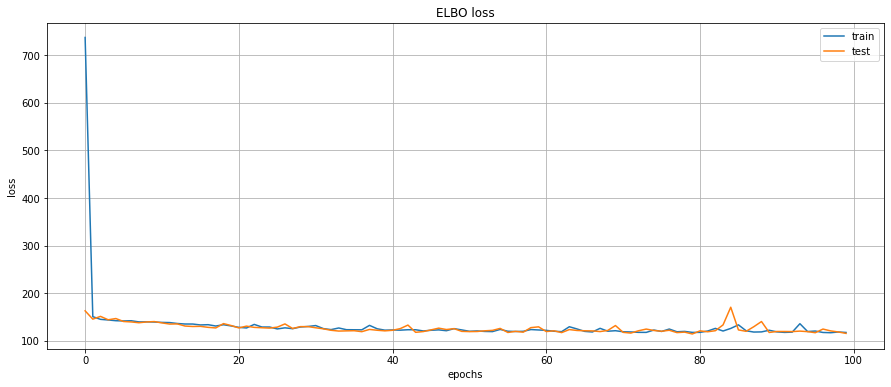

In [132]:
elbo_losses_tr, elbo_losses_te, kl_losses_tr, kl_losses_te = [], [], [], []

for epoch in range(100):
    elbo_loss_tr, elbo_loss_te = 0, 0
    for i, inputs in enumerate(train_loader_art):
        inputs = inputs.view(BATCH_SIZE, 1, -1, 1).float()
        # inputs = inputs.to(DEVICE)
        outputs, h, mu, gamma = model_vae_art(inputs)  

        elbo_loss, KL_loss, weighted_reconstruction_error_dataset, ls_reconstruction_error, sigma1, sigma_reg = model_vae_art.define_loss(inputs, 
                                                                                                                                      outputs, 
                                                                                                                                      mu, gamma)

        optimizer_vae.zero_grad()
        elbo_loss.backward()
        optimizer_vae.step()

        elbo_loss_tr += elbo_loss.item()
        
    elbo_losses_tr.append(elbo_loss_tr/len(train_loader_art))
    if epoch % 10 == 0:
      print('EPOCH #', epoch)
      print('elbo tr', elbo_loss_tr/len(train_loader_art))

    # print('train loss', elbo_losses_tr[epoch])

    for i, inputs in enumerate(val_loader_art):
        inputs = inputs.view(BATCH_SIZE, 1, -1, 1).float()
        # inputs = inputs.to(DEVICE)
        outputs, h, mu, gamma = model_vae_art(inputs)
        elbo_loss, KL_loss, weighted_reconstruction_error_dataset, ls_reconstruction_error, sigma1, sigma_reg = model_vae_art.define_loss(inputs, 
                                                                                                                                      outputs, 
                                                                                                                                      mu, gamma)
        elbo_loss_te += elbo_loss.item()

    if epoch % 10 == 0:
        print('elbo te', elbo_loss_te/len(val_loader_art))
    elbo_losses_te.append(elbo_loss_te/len(val_loader_art))

    # print('test loss', elbo_losses_te[epoch])


fig = plt.figure(figsize=(15, 6))


plt.plot(elbo_losses_tr, label = 'train')
plt.plot(elbo_losses_te, label = 'test')
plt.title('ELBO loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc = 'upper right')
plt.grid()


plt.show()


In [133]:
BATCH_SIZE = 32
lstm_model_art = LSTMmodel(config)
x_train, y_train, x_test, y_test, inputs_tr, inputs_te, mu_tr, mu_te, gamma_tr, gamma_te = lstm_model_art.produce_embeddings(config, model_vae_art, data_art)
train_loader_lstm = DataLoader(TimeSeriesDataSet(x_train, y_train), batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader_lstm = DataLoader(TimeSeriesDataSet(x_test, y_test), batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
optimizer_lstm = optim.Adam(lstm_model_art.parameters(), lr=config['learning_rate_lstm'])
loss_lstm = nn.MSELoss()

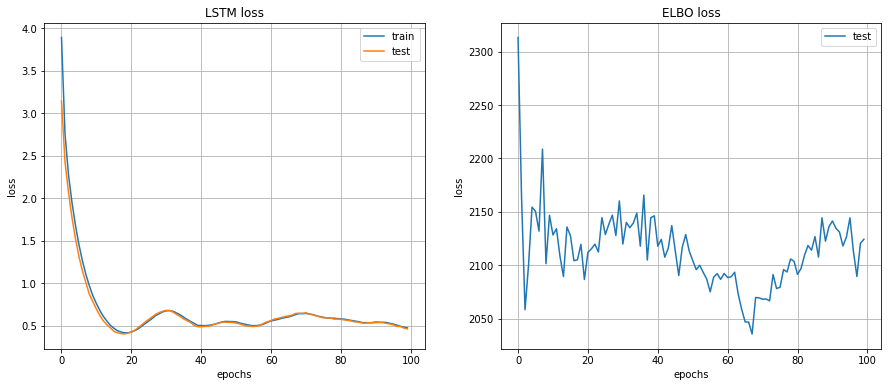

In [134]:
losses_lstm_tr, losses_lstm_te, elbo_losses_te = [], [], []
for epoch in range(100):
    train_loss_lstm, test_loss_lstm, elbo_loss_te = 0, 0, 0
    for i, data_tr in enumerate(train_loader_lstm):
        
        inputs_lstm, labels = data_tr[0], data_tr[1]
        inputs_lstm = inputs_lstm.float()
        # print(inputs_lstm.shape)
        outputs_lstm, (hid_st, st_cell) = lstm_model_art(inputs_lstm)
        # print(outputs_lstm.shape)
        loss_l = loss_lstm(labels.float(), outputs_lstm.float()) 
        optimizer.zero_grad()
        loss_l.backward()
        optimizer_lstm.step()
        train_loss_lstm += loss_l.item()
        final_output = model_vae_art.decoder(hid_st)
        # print(inputs_tr[0:1])

    losses_lstm_tr.append(train_loss_lstm/len(train_loader_lstm))

    for i, data_te in enumerate(test_loader_lstm):
        # print(i)
        inputs_lstm, labels = data_te[0], data_te[1]
        inputs_lstm = inputs_lstm.float()
        outputs_lstm, (hid_st, st_cell) = lstm_model_art(inputs_lstm)

        loss_l = loss_lstm(labels, outputs_lstm)
        test_loss_lstm += loss_l.item()

        predict = model_vae_art.decoder(hid_st)
        # print(len(inputs_te))
        elbo_loss, KL_loss, weighted_reconstruction_error_dataset, ls_reconstruction_error, sigma, sigma_rec = model_vae_art.define_loss(inputs_te[(i+1) * BATCH_SIZE: (i+2) * BATCH_SIZE][0][:], 
                                                                                                                                     predict, 
                                                                                                                                     mu_te[(i+1) * BATCH_SIZE: (i+2) * BATCH_SIZE][0][:], 
                                                                                                                                     gamma_te[(i+1) * BATCH_SIZE: (i+2) * BATCH_SIZE][0][:])
        elbo_loss_te += elbo_loss.item()

    losses_lstm_te.append(test_loss_lstm/len(test_loader_lstm))
    elbo_losses_te.append(elbo_loss_te/len(train_loader_lstm))

fig = plt.figure(figsize=(15, 6))


ax = fig.add_subplot(121)
ax.plot(losses_lstm_tr, label = 'train')
ax.plot(losses_lstm_te, label = 'test')
plt.title('LSTM loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc = 'upper right')
plt.grid()

ax2 = fig.add_subplot(122)
ax2.plot(elbo_losses_te, label = 'test')
plt.title('ELBO loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(loc = 'upper right')
plt.grid()



plt.show() 

In [135]:
result = dataset

test_windows, test_seq, test_sample_m, test_sample_std = slice_rolling_windows_and_sequences(config, result['test'])
test_windows = np.expand_dims(test_windows, -1)
test_seq = np.expand_dims(test_seq, -1)
print(test_windows.shape)
print(test_seq.shape)

n_val_vae = data_art.val_set_vae['data'].shape[0]
n_val_lstm = data_art.val_set_lstm['data'].shape[0]

val_vae_recons_error = np.zeros(n_val_vae)
val_vae_kl_error = np.zeros(n_val_vae)
val_vae_elbo_loss = np.zeros(n_val_vae)
for i in range(n_val_vae):
    val_vae_recons_error[i], val_vae_kl_error[i], val_vae_elbo_loss[i] = evaluate_vae_anomaly_metrics_for_a_window(data_art.val_set_vae['data'][i], model_vae_art)

val_lstm_recons_error, val_lstm_embedding_error = np.zeros(n_val_lstm), np.zeros(n_val_lstm)
for i in range(n_val_lstm):
    val_lstm_recons_error[i], val_lstm_embedding_error[i] = evaluate_lstm_anomaly_metric_for_a_seq(data_art.val_set_lstm['data'][i], model_vae_art, lstm_model)


The given sequence has 2999 samples
(2952, 48, 1)
(2424, 12, 48, 1)


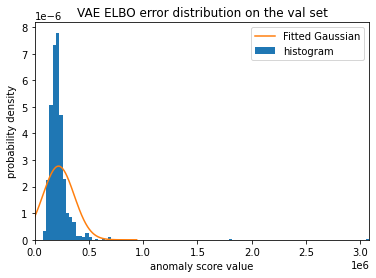

25% percentile: 169991.14906877078
75% percentile: 239308.77704013762
These windows scored the top 1% of anomaly metric (521070.69765141094): 
[  4  65 116 175 276 306 479]


In [136]:
# Histogram of VAE ELBO loss - validation set
vae_elbo_m, vae_elbo_std = plot_histogram(val_vae_elbo_loss, 100, 
                                          'VAE ELBO error distribution on the val set', 
                                          mean=None, std=None, xlim=None)

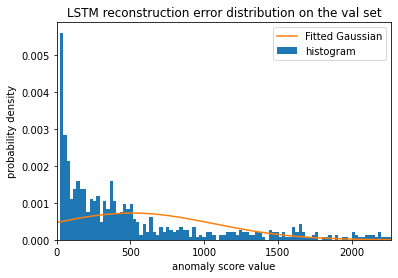

25% percentile: 102.09250332286126
75% percentile: 670.3971866451749
These windows scored the top 1% of anomaly metric (2160.4551988635576): 
[ 87 134 176 330 423 542 590]


In [137]:
# Histogram of LSTM reconstruction error - validation set 
#  --> to decide the anomaly detection threshold
lstm_recons_m, lstm_recons_std = plot_histogram(val_lstm_recons_error, 100,  
                                              'LSTM reconstruction error distribution on the val set', 
                                              mean=None, std=None, xlim=None)

In [138]:
# Evaluate the anomaly metrics on the test windows and sequences
n_test_lstm = test_seq.shape[0]

test_lstm_recons_error, test_lstm_embedding_error = np.zeros(n_test_lstm), np.zeros(n_test_lstm)
for i in range(n_test_lstm):
    test_lstm_recons_error[i], test_lstm_embedding_error[i] = evaluate_lstm_anomaly_metric_for_a_seq(test_seq[i], model_vae_art, lstm_model)
print("All windows' reconstruction error is computed.")
print("The total number of windows is {}".format(len(test_lstm_recons_error)))

All windows' reconstruction error is computed.
The total number of windows is 2424


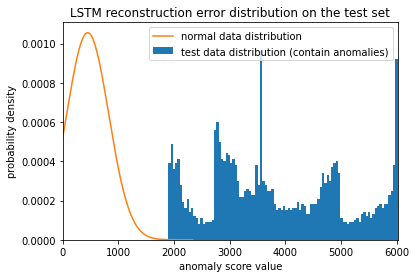

25% percentile: 2878.708635918137
75% percentile: 4807.359780391983
These windows scored the top 1% of anomaly metric (6003.859180216003): 
[841 842 843 844 845 846 847 848 849 850 851 852 853 854 855 856 857 858
 859 860 861 862 863 864 865]


In [124]:
# Histogram of LSTM reconstruction error - test set 
#  --> to detect anomaly now
_, _ = plot_histogram(test_lstm_recons_error, 100,
                      'LSTM reconstruction error distribution on the test set', 
                      mean=lstm_recons_m, std=lstm_recons_std, xlim=None)

In [125]:
# Produce the ground truth anomaly indices 

idx_anomaly_test = result['idx_anomaly_test']    
anomaly_index_lstm = []
test_labels_lstm = np.zeros(n_test_lstm)
for i in range(len(idx_anomaly_test)):
    idx_start = idx_anomaly_test[i]-(config['l_win']*config['l_seq']-1)
    # print(idx_start)
    idx_end = idx_anomaly_test[i]+1
    # print(idx_end)
    if idx_start < 0:
        idx_start = 0
    if idx_end > n_test_lstm:
        idx_end = n_test_lstm
    anomaly_index_lstm.append(np.arange(idx_start,idx_end))
    test_labels_lstm[idx_start:idx_end] = 1
    
print(test_labels_lstm.shape)

(2424,)


In [126]:
n_threshold = 200
precision = np.zeros(n_threshold)
recall = np.zeros(n_threshold)
F1 = np.zeros(n_threshold)
precision_aug = np.zeros(n_threshold)
recall_aug = np.zeros(n_threshold)
F1_aug = np.zeros(n_threshold)
i = 0
threshold_list = np.linspace(np.amin(test_lstm_recons_error), np.amax(test_lstm_recons_error), n_threshold, endpoint=True)
threshold_list = np.flip(threshold_list)
for threshold in threshold_list:
    #print(threshold_list[i])
    idx_detection_lstm = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
    precision[i], recall[i], F1[i], _, _, _ = compute_precision_and_recall(idx_detection_lstm, 
                                                                           anomaly_index_lstm, 
                                                                           test_labels_lstm)
    # augment the detection using the ground truth labels
    # a method to discount the factor one anomaly appears in multiple consecutive windows
    idx_detection_lstm_augmented = augment_detected_idx(idx_detection_lstm, anomaly_index_lstm)
    precision_aug[i], recall_aug[i], F1_aug[i], _, _, _ = compute_precision_and_recall(idx_detection_lstm_augmented, 
                                                                                       anomaly_index_lstm, 
                                                                                       test_labels_lstm)
    i = i + 1
    # print(precision, recall, F1)

In [127]:
print("Best F1 score is {}".format(np.amax(F1)))
idx_best_threshold = np.squeeze(np.argwhere(F1 == np.amax(F1)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision[idx_best_threshold], recall[idx_best_threshold]))
average_precision = np.sum(precision[1:] * (recall[1:] - recall[:-1]))
print("Average precision is {}".format(average_precision))

print("\nAugmented detection:")
print("Best F1 score is {}".format(np.amax(F1_aug)))
idx_best_threshold = np.squeeze(np.argwhere(F1_aug == np.amax(F1_aug)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision_aug[idx_best_threshold], 
                                                                recall_aug[idx_best_threshold]))

average_precision_aug = np.sum(precision_aug[1:] * (recall_aug[1:] - recall_aug[:-1]))
print("Average precision is {}".format(average_precision_aug))

Best F1 score is 0.7265846736045412
Best threshold is 2722.9286860128896
At this threshold, precision is 0.5705794947994056, recall is 1.0
Average precision is 0.7388647645441043

Augmented detection:
Best F1 score is 0.8787185354691075
Best threshold is 4255.996265168364
At this threshold, precision is 0.7836734693877551, recall is 1.0
Average precision is 0.8918367346938776


In [128]:
# Now select a threshold
threshold = 4255

print("Threshold is {}".format(threshold))
idx_detection = return_anomaly_idx_by_threshold(test_lstm_recons_error, threshold)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index_lstm)
precision, recall, F1, n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index_lstm, 
                                                                       test_labels_lstm)
print("\nPR evaluation using augmented detection:")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

Threshold is 4255

PR evaluation using augmented detection:
Precision: 0.7836734693877551
Recall: 1.0
F1: 0.8787185354691075
TP: 1152
FP: 318
FN: 0


Detected 2 sequences


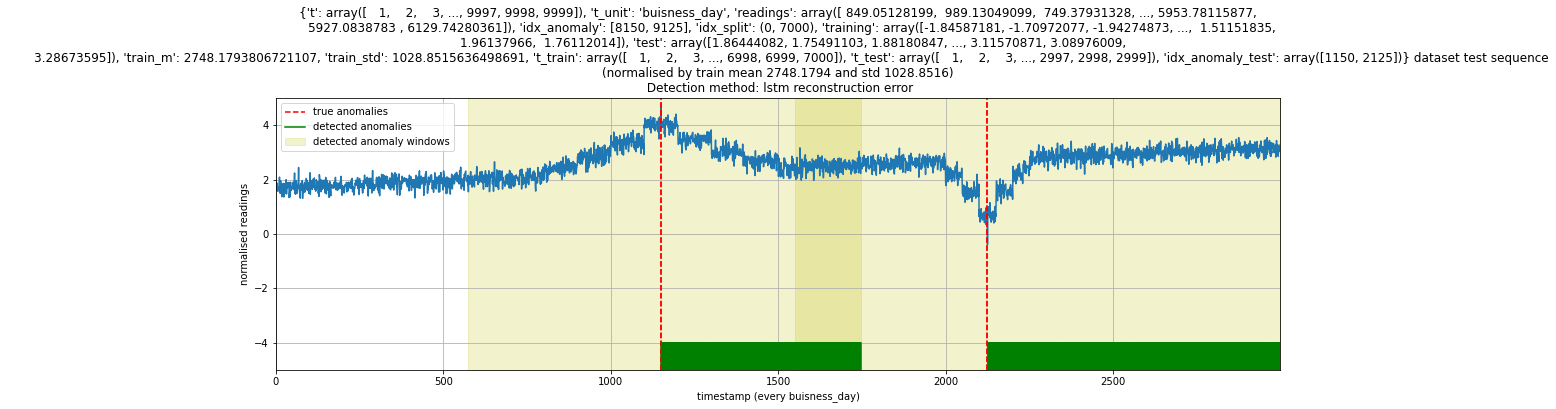

In [129]:
plot_detected_anomalies(idx_detection_augmented, 
                        interval=config['l_win']*config['l_seq']/2, 
                        dataset=dataset, 
                        result=result, 
                        detection_method='lstm reconstruction error',
                        augmented_flag=1,
                        y_scale=5,
                        y_lim=5)

@INPROCEEDINGS{VAE-LSTM-AD, 
   author={S. {Lin} and R. {Clark} and R. {Birke} and S. {Schönborn} and N. {Trigoni} and S. {Roberts}}, 
   booktitle={ICASSP 2020 - 2020 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP)}, 
   title={Anomaly Detection for Time Series Using VAE-LSTM Hybrid Model}, 
   year={2020}} 